In [5]:


import requests
import pandas as pd
import time

def fetch_paginated_klines(symbol, interval="1m", start_time=None, end_time=None):
    all_data = []
    chunk_size = 1000 * 60 * 1000  # 1000 minutes in milliseconds

    while start_time < end_time:
        chunk_end = min(start_time + chunk_size, end_time)
        url = f"https://api.mexc.com/api/v3/klines"
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "endTime": chunk_end,
            "limit": 1000
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            chunk_data = response.json()
            if not chunk_data:
                print(f"⚠️ No data in chunk {start_time} – {chunk_end}")
            all_data.extend(chunk_data)
        else:
            print(f"❌ Error {response.status_code}: {response.text}")
            break

        start_time = chunk_end
        time.sleep(0.25)  # Respect rate limits

    if not all_data:
        print("🚫 No data fetched.")
        return pd.DataFrame()

    df = pd.DataFrame(all_data, columns=[
  "Open Time", "Open", "High", "Low", "Close", "Volume",
  "Close Time", "Quote Asset Volume"
    ])
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit="ms")
    return df

# 🕒 Example: Fetch last 12 hours for BTCUSDT
end = int(time.time() * 1000)
start = end - (120 * 60 * 60 * 1000)

df = fetch_paginated_klines("BTCUSDT", start_time=start, end_time=end)
#print(df.head())
print(f"✅ Total rows fetched: {len(df)}")
# Make sure Close is float
df["Close"] = df["Close"].astype(float)
# Calculate short_ema   and EMA 21

##############################

short_ema=6
long_ema= 9

##############################

# Calculate custom EMAs
df["EMA_short"] = df["Close"].ewm(span=short_ema, adjust=False).mean()
df["EMA_long"]  = df["Close"].ewm(span=long_ema, adjust=False).mean()

# Generate crossover signals
buy_signals = (df["EMA_short"] > df["EMA_long"]) & (df["EMA_short"].shift(1) <= df["EMA_long"].shift(1))
sell_signals = (df["EMA_short"] < df["EMA_long"]) & (df["EMA_short"].shift(1) >= df["EMA_long"].shift(1))
#Only trade when EMA pairs show clear direction:
trend_ok = df["EMA_short"] > df["EMA_long"]
buy_signals = buy_signals & trend_ok

 

✅ Total rows fetched: 3700


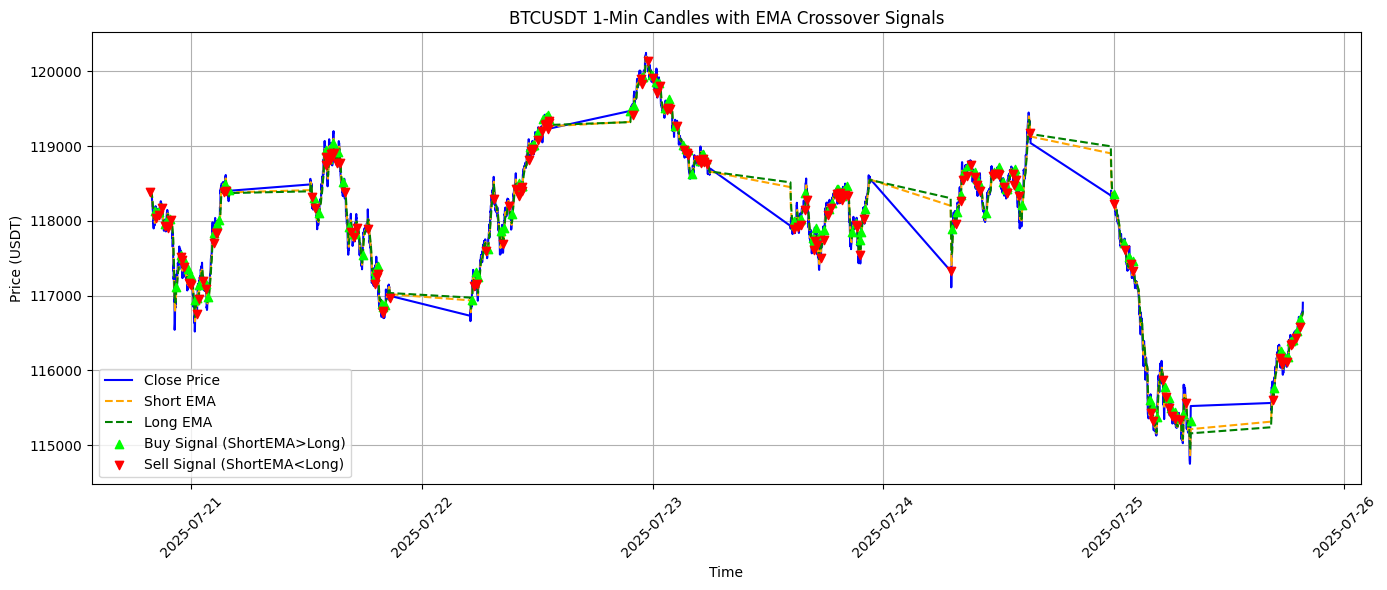

In [6]:
import matplotlib.pyplot as plt

 
 
# Plotting
plt.figure(figsize=(14,6))
plt.plot(df["Open Time"], df["Close"], label="Close Price", color="blue", linewidth=1.5)
plt.plot(df["Open Time"], df["EMA_short"], label="Short EMA", color="orange", linestyle="--")
plt.plot(df["Open Time"], df["EMA_long"], label="Long EMA", color="green", linestyle="--")

# Add markers for crossover signals
plt.scatter(df["Open Time"][buy_signals], df["Close"][buy_signals],
            marker="^", color="lime", label="Buy Signal (ShortEMA>Long)", zorder=5)
plt.scatter(df["Open Time"][sell_signals], df["Close"][sell_signals],
            marker="v", color="red", label="Sell Signal (ShortEMA<Long)", zorder=5)

# Format chart
plt.title("BTCUSDT 1-Min Candles with EMA Crossover Signals")
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Ensure price column is float
df["Close"] = df["Close"].astype(float)

 

# Create a trade log
trades = []
position = None
entry_price = 0

for i in range(len(df)):
    time = df["Open Time"].iloc[i]
    price = df["Close"].iloc[i]

    if buy_signals.iloc[i] and position is None:
        position = "LONG"
        entry_price = price
        trades.append({"Time": time, "Type": "Buy", "Price": entry_price})

    elif sell_signals.iloc[i] and position == "LONG":
        exit_price = price
        pnl = exit_price - entry_price
        trades.append({"Time": time, "Type": "Sell", "Price": exit_price, "PnL": pnl})
        position = None

# Convert trade log to DataFrame
trades_df = pd.DataFrame(trades)

# Calculate total PnL
total_pnl = trades_df["PnL"].sum() if "PnL" in trades_df.columns else 0.0

 
print(f"💰 Total PnL (based on EMA strategy): {total_pnl:.2f} USDT")

# Build trade log



#Create equity curve from cumulative PnL
completed_trades = trades_df[trades_df["Type"] == "Sell"].copy()
completed_trades["CumPnL"] = completed_trades["PnL"].cumsum()







# Filter only completed trades (SELL entries with PnL)
completed_trades = trades_df[trades_df["Type"] == "Sell"].copy()

# Calculate cumulative PnL over time
completed_trades["CumPnL"] = completed_trades["PnL"].cumsum()

# Preview
print(completed_trades[["Time", "Price", "PnL", "CumPnL"]])


# 📊 Statistics
num_buys = trades_df["Type"].value_counts().get("Buy", 0)
num_sells = trades_df["Type"].value_counts().get("Sell", 0)
num_trades = min(num_buys, num_sells)  # matched pairs only
 

# Filter only completed trades (those with PnL)
completed_trades = trades_df[trades_df["Type"] == "Sell"]

# Calculate metrics
total_pnl = completed_trades["PnL"].sum()
win_trades = completed_trades[completed_trades["PnL"] > 0]
loss_trades = completed_trades[completed_trades["PnL"] <= 0]

win_rate = (len(win_trades) / len(completed_trades)) * 100 if len(completed_trades) > 0 else 0
average_pnl = total_pnl / len(completed_trades) if len(completed_trades) > 0 else 0

# Print stats
print(trades_df)
print(f"\n📈 Trade Summary:")
print(f"→ Total Buy signals: {num_buys}")
print(f"→ Total Sell signals: {num_sells}")
print(f"→ Completed Trades: {num_trades}")
print(f"→ Winning Trades: {len(win_trades)}")
print(f"→ Losing Trades: {len(loss_trades)}")
print(f"→ Win Rate: {win_rate:.2f}%")
print(f"→ Average PnL per Trade: {average_pnl:.2f} USDT")
print(f"→ Total PnL: {total_pnl:.2f} USDT")





💰 Total PnL (based on EMA strategy): -563.94 USDT
                   Time      Price     PnL  CumPnL
1   2025-07-20 20:22:00  118038.26  -99.07  -99.07
3   2025-07-20 20:36:00  118073.63  -46.36 -145.43
5   2025-07-20 20:55:00  118167.14   47.15  -98.28
7   2025-07-20 21:17:00  117932.45  -31.22 -129.50
9   2025-07-20 21:37:00  117912.00  -73.57 -203.07
..                  ...        ...     ...     ...
291 2025-07-25 17:58:00  116120.03  -79.68 -767.89
293 2025-07-25 18:27:00  116347.19  167.93 -599.96
295 2025-07-25 18:33:00  116350.09  -49.89 -649.85
297 2025-07-25 19:00:00  116431.20   27.18 -622.67
299 2025-07-25 19:22:00  116585.95   58.73 -563.94

[150 rows x 4 columns]
                   Time  Type      Price    PnL
0   2025-07-20 20:15:00   Buy  118137.33    NaN
1   2025-07-20 20:22:00  Sell  118038.26 -99.07
2   2025-07-20 20:30:00   Buy  118119.99    NaN
3   2025-07-20 20:36:00  Sell  118073.63 -46.36
4   2025-07-20 20:37:00   Buy  118119.99    NaN
..                  ...   

In [8]:
#ema_ranges = [(5, 21), (9, 21), (10, 30), (12, 26), (20, 50),(9, 15)]

ema_ranges = [(short, long) for short in range(4, 30, 2)
              for long in range(short + 5, short + 31, 5)]

results = []

for short_span, long_span in ema_ranges:
    df["EMA_short"] = df["Close"].astype(float).ewm(span=short_span, adjust=False).mean()
    df["EMA_long"] = df["Close"].astype(float).ewm(span=long_span, adjust=False).mean()

    # Generate crossover signals
    buy_signals = (df["EMA_short"] > df["EMA_long"]) & (df["EMA_short"].shift(1) <= df["EMA_long"].shift(1))
    sell_signals = (df["EMA_short"] < df["EMA_long"]) & (df["EMA_short"].shift(1) >= df["EMA_long"].shift(1))

    trades = []
    position = None
    entry_price = 0

    for i in range(len(df)):
        time = df["Open Time"].iloc[i]
        price = df["Close"].iloc[i]

        if buy_signals.iloc[i] and position is None:
            position = "LONG"
            entry_price = price
            trades.append({"Time": time, "Type": "Buy", "Price": entry_price})

        elif sell_signals.iloc[i] and position == "LONG":
            exit_price = price
            pnl = exit_price - entry_price
            trades.append({"Time": time, "Type": "Sell", "Price": exit_price, "PnL": pnl})
            position = None

    # Evaluate performance
    trades_df = pd.DataFrame(trades)
    completed = trades_df[trades_df["Type"] == "Sell"]
    total_pnl = completed["PnL"].sum()
    win_rate = len(completed[completed["PnL"] > 0]) / len(completed) * 100 if len(completed) > 0 else 0

    results.append({
        "EMA_short": short_span,
        "EMA_long": long_span,
        "Total PnL": total_pnl,
        "Win Rate": round(win_rate, 2),
        "Trades": len(completed)
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Total PnL", ascending=False))


    EMA_short  EMA_long  Total PnL  Win Rate  Trades
44         18        33    1475.64     30.56      36
35         14        44    1434.78     25.00      36
49         20        30    1365.60     33.33      36
39         16        36    1187.20     28.95      38
34         14        39    1140.08     28.21      39
..        ...       ...        ...       ...     ...
30         14        19   -1574.31     31.75      63
31         14        24   -1682.15     26.23      61
25         12        22   -1774.47     31.25      64
36         16        21   -2002.79     27.69      65
5           4        34   -2374.65     21.28      94

[78 rows x 5 columns]
